In [ ]:
!pip install -q datasets transformers sentencepiece

     |████████████████████████████████| 365 kB 5.3 MB/s 
     |████████████████████████████████| 4.7 MB 47.8 MB/s 
     |████████████████████████████████| 1.2 MB 49.1 MB/s 
     |████████████████████████████████| 212 kB 62.1 MB/s 
     |████████████████████████████████| 141 kB 35.3 MB/s 
     |████████████████████████████████| 115 kB 11.3 MB/s 
     |████████████████████████████████| 101 kB 7.1 MB/s 
     |████████████████████████████████| 596 kB 55.0 MB/s 
     |████████████████████████████████| 127 kB 46.8 MB/s 
     |████████████████████████████████| 6.6 MB 47.2 MB/s 


In [ ]:
import numpy as np
import pandas as pd
import datasets
from datasets import Dataset, DatasetDict
import os
import random
import regex as re
import logging
import gc
from tqdm import tqdm, trange
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, classification_report
from datasets import load_dataset
import torch
import torch.nn as nn
from transformers import AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from transformers import XLMRobertaTokenizer
from transformers.models.xlm_roberta.modeling_xlm_roberta import  XLMRobertaModel, XLMRobertaConfig
from transformers import BertConfig, BertTokenizer, BertModel
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

In [ ]:
dataset = load_dataset('scitail', 'tsv_format')

08/05/2022 13:46:10 - WARNING - datasets.builder -   Reusing dataset scitail (/root/.cache/huggingface/datasets/scitail/tsv_format/1.1.0/0f221f9167f070d3e492b35010923cdf411c288f9ed5b8dc51f0cb011e773ee5)


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
# from torch.utils.data import Subset
# dataset['train'] = dataset['train'].shuffle(seed=42)
# dataset['train'] = Subset(dataset["train"], list(range(1523)))

In [ ]:
Entailment_Forgettables_Info = pd.read_csv('/content/Entailment_Forgettables_Info.csv')
Entailment_Forgettables_Info

,Unnamed: 0,sample_index,forgetting_events,True_label_indexes
0,0,29,1,[2 4 5 6 7 8 9]
1,1,33,1,[0 2 3 4 5 6 7 8 9]
2,2,34,1,[0 5 6 7 8 9]
3,3,50,1,[0 3 4 5 6 7 8 9]
4,4,51,1,[0 1 3 4 5 6 7 8 9]
...,...,...,...,...
1518,1518,23032,1,[0 1 2 3 4 6 7 8 9]
1519,1519,23048,1,[0 1 3 4 5 6 7 8 9]
1520,1520,23067,1,[0 1 2 3 5 6 7 8 9]
1521,1521,23074,1,[0 1 3 4 5 6 7 8 9]


In [ ]:
dataset['train'] = Dataset.from_pandas(pd.DataFrame.from_dict([dataset['train'][idx] for idx in Entailment_Forgettables_Info['sample_index']]))
dataset['train']

Dataset({
    features: ['premise', 'hypothesis', 'label'],
    num_rows: 1523
})

{'entails': 0.4783180026281209, 'neutral': 0.5223390275952694}

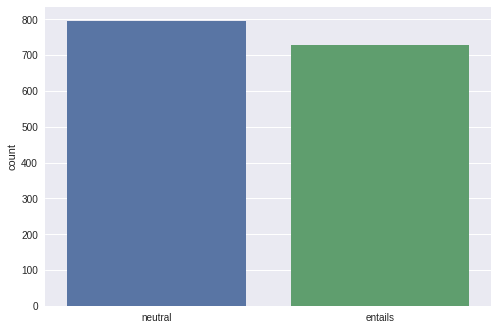

In [ ]:
freq_dict = dict()
for data in dataset['train']:
    if (data['label'] in freq_dict): freq_dict[data['label']] += 1
    else: freq_dict[data['label']] = 1

for k,v in freq_dict.items():
    freq_dict[k] = v / (len(dataset['train']) - 1)

sns.countplot(x=dataset['train']['label'])
freq_dict

{'entails': 0.5038343558282209, 'neutral': 0.49616564417177916}

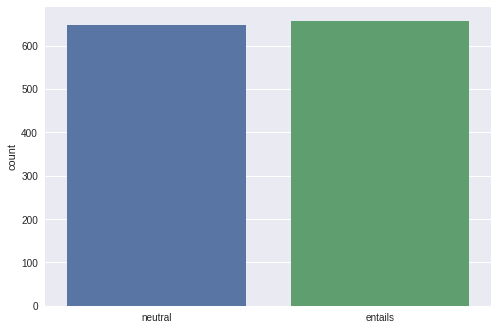

In [ ]:
freq_dict = dict()
for data in dataset['validation']:
    if (data['label'] in freq_dict): freq_dict[data['label']] += 1
    else: freq_dict[data['label']] = 1

for k,v in freq_dict.items():
    freq_dict[k] = v / (len(dataset['validation']))

sns.countplot(x=dataset['validation']['label'])
freq_dict

{'entails': 0.3964218455743879, 'neutral': 0.6045197740112994}

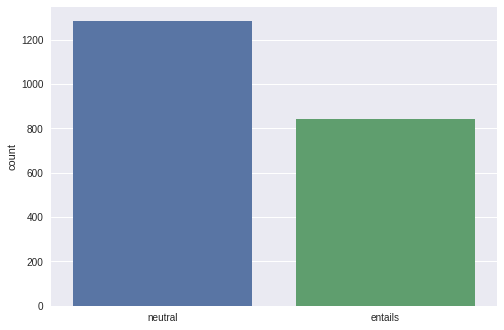

In [ ]:
freq_dict = dict()
for data in dataset['test']:
    if (data['label'] in freq_dict): freq_dict[data['label']] += 1
    else: freq_dict[data['label']] = 1

for k,v in freq_dict.items():
    freq_dict[k] = v / (len(dataset['test']) - 2)

sns.countplot(x=dataset['test']['label'])
freq_dict

In [ ]:
class Textual_EntailementClassifier(nn.Module):
    def __init__(self, input_dim, num_labels=3, dropout_rate=0.):
        super(Textual_EntailementClassifier, self).__init__()
        self.dropout = nn.Dropout(dropout_rate)
        self.linear1 = nn.Linear(input_dim, input_dim // 3)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(input_dim // 3, num_labels)

    def forward(self, x):
        x = self.dropout(x)
        x = self.linear1(x)
        x = self.relu(x)
        return self.linear2(x)

In [ ]:
class BERT_Textual_Entailement(BertModel):
    def __init__(self, config, args, label_lst):
        super(BERT_Textual_Entailement, self).__init__(config)
        self.args = args
        self.num_labels = len(set(label_lst))
        self.bert = BertModel(config=config) # Load pretrained Bert
        self.classifier = Textual_EntailementClassifier(config.hidden_size, self.num_labels, args.dropout_rate)

    def forward(self, input_ids, attention_mask, token_type_ids, label_ids):
        outputs = self.bert(input_ids, attention_mask, token_type_ids)  # sequence_output, pooled_output, (hidden_states), (attentions)
        pooled_output = outputs[1]  # [CLS]
        label_logits = self.classifier(pooled_output)

        total_loss = 0
        # Softmax
        if label_ids is not None:
            loss = 0
            if self.num_labels == 1:
                loss_fct = nn.MSELoss()
                loss = loss_fct(label_logits.view(-1), label_ids.view(-1))
            else:
                loss_fct = nn.CrossEntropyLoss()
                loss = loss_fct(label_logits.view(-1, self.num_labels), label_ids.view(-1))
            total_loss += loss

        outputs = (label_logits,) + outputs[2:]  # add hidden states and attention if they are here
        outputs = (total_loss,) + outputs

        return outputs  # (loss), logits, (hidden_states), (attentions)

In [ ]:
class ParsBERT_Textual_Entailement(BertModel):
    def __init__(self, config, args, label_lst):
        super(ParsBERT_Textual_Entailement, self).__init__(config)
        self.args = args
        self.num_labels = len(set(label_lst))
        self.parsbert = BertModel(config=config) # Load pretrained ParsBert
        self.classifier = Textual_EntailementClassifier(config.hidden_size, self.num_labels, args.dropout_rate)

    def forward(self, input_ids, attention_mask, token_type_ids, label_ids):
        outputs = self.parsbert(input_ids, attention_mask, token_type_ids)  # sequence_output, pooled_output, (hidden_states), (attentions)
        pooled_output = outputs[1]  # [CLS]
        label_logits = self.classifier(pooled_output)

        total_loss = 0
        # Softmax
        if label_ids is not None:
            loss = 0
            if self.num_labels == 1:
                loss_fct = nn.MSELoss()
                loss = loss_fct(label_logits.view(-1), label_ids.view(-1))
            else:
                loss_fct = nn.CrossEntropyLoss()
                loss = loss_fct(label_logits.view(-1, self.num_labels), label_ids.view(-1))
            total_loss += loss

        outputs = (label_logits,) + outputs[2:]  # add hidden states and attention if they are here
        outputs = (total_loss,) + outputs

        return outputs  # (loss), logits, (hidden_states), (attentions)

In [ ]:
MODEL_CLASSES = {
    'bert': (BertConfig, BERT_Textual_Entailement, BertTokenizer),
    'parsbert': (BertConfig, ParsBERT_Textual_Entailement, BertTokenizer),
}

MODEL_PATH_MAP = {
    # 'XLMRoberta': 'xlm-roberta-base',
    'bert': 'bert-base-uncased',
    'parsbert': 'HooshvareLab/bert-fa-zwnj-base',
}

logger = logging.getLogger(__name__)

In [ ]:
def load_tokenizer(args):
    return MODEL_CLASSES[args.model_type][2].from_pretrained(args.model_name_or_path)

def init_logger():
    logging.basicConfig(format='%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
                        datefmt='%m/%d/%Y %H:%M:%S',
                        level=logging.INFO)
    
def label2index(label):
    if (label == 'neutral'): return 0
    elif (label == 'entails'): return 1
    # else: return 2

def get_labels(dataset):
  train_label = list()
  for data in dataset:
      if (data['label'] != 'xx' and data['label'] != '-'): train_label.append(data['label'])
  
  return train_label

def set_seed(args):
    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    if not args.no_cuda and torch.cuda.is_available():
        torch.cuda.manual_seed_all(args.seed)

In [ ]:
def prepare_dataset(data, args, tokenizer, padding='max_length'):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    all_label = torch.tensor([label2index(x['label']) for x in data if  (x['label'] != 'xx' and x['label'] != '-')], dtype=torch.long).to(device)
    bert_input = tokenizer([x['premise'] for x in data if (x['label'] != 'xx' and x['label'] != '-')] , [x['hypothesis'] for x in data if (x['label'] != 'xx' and x['label'] != '-')], padding=padding, max_length=args.max_seq_len, truncation=True, return_tensors="pt")
    if ('token_type_ids' in bert_input):
        dataset = TensorDataset(bert_input['input_ids'].to(device), bert_input['attention_mask'].to(device), bert_input['token_type_ids'].to(device), all_label)
    else:
        dataset = TensorDataset(bert_input['input_ids'].to(device), bert_input['attention_mask'].to(device), torch.zeros_like(bert_input['input_ids']).to(device), all_label)

    return dataset

In [ ]:
#define
OUTPUT_DIM = 2
NUM_EPOCHS = 10
Prob_per_epoch = np.zeros((NUM_EPOCHS,len(dataset['train']),OUTPUT_DIM)) #2 labels

class Trainer(object):
    def __init__(self, args, train_dataset=None, dev_dataset=None, test_dataset=None):
        self.args = args
        self.train_dataset = train_dataset
        self.dev_dataset = dev_dataset
        self.test_dataset = test_dataset

        self.label_lst = get_labels(dataset['train'])

        self.config_class, self.model_class, _ = MODEL_CLASSES[args.model_type]
        self.config = self.config_class.from_pretrained(args.model_name_or_path, finetuning_task=args.task)
        self.model = self.model_class.from_pretrained(args.model_name_or_path,
                                                      config=self.config,
                                                      args=args,
                                                      label_lst=self.label_lst)
                                                      

        # GPU or CPU
        self.device = "cuda" if torch.cuda.is_available() and not args.no_cuda else "cpu"
        self.model.to(self.device)

    def train(self):
        # train_sampler = RandomSampler(self.train_dataset)
        train_sampler = SequentialSampler(self.train_dataset)
        train_dataloader = DataLoader(self.train_dataset, sampler=train_sampler, batch_size=self.args.train_batch_size)
        if self.args.max_steps > 0:
            t_total = self.args.max_steps
            self.args.num_train_epochs = self.args.max_steps // (len(train_dataloader) // self.args.gradient_accumulation_steps) + 1
        else:
            t_total = len(train_dataloader) // self.args.gradient_accumulation_steps * self.args.num_train_epochs

        # Prepare optimizer and schedule (linear warmup and decay)
        no_decay = ['bias', 'LayerNorm.weight']
        optimizer_grouped_parameters = [
            {'params': [p for n, p in self.model.named_parameters() if not any(nd in n for nd in no_decay)],
             'weight_decay': self.args.weight_decay},
            {'params': [p for n, p in self.model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ]
        optimizer = AdamW(optimizer_grouped_parameters, lr=self.args.learning_rate, eps=self.args.adam_epsilon)
        scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=self.args.warmup_steps, num_training_steps=t_total)

        # Train!
        logger.info("***** Running training *****")
        logger.info("  Num examples = %d", len(self.train_dataset))
        logger.info("  Num Epochs = %d", self.args.num_train_epochs)
        logger.info("  Total train batch size = %d", self.args.train_batch_size)
        logger.info("  Gradient Accumulation steps = %d", self.args.gradient_accumulation_steps)
        logger.info("  Total optimization steps = %d", t_total)
        logger.info("  Logging steps = %d", self.args.logging_steps)
        logger.info("  Save steps = %d", self.args.save_steps)

        global_step = 0
        tr_loss = 0.0
        self.model.zero_grad()
        best_acc = -1
       
        train_iterator = trange(int(self.args.num_train_epochs), desc="Epoch")
        for epoch in train_iterator:
            label_preds = None
            out_label_ids = None
            # epoch_iterator = tqdm(train_dataloader, desc="Iteration")
            stacked_train_preds = None
            for step, batch in enumerate(train_dataloader):
                self.model.train()
                inputs = {'input_ids': batch[0],
                          'attention_mask': batch[1],
                          'token_type_ids': batch[2],
                          'label_ids': batch[3]}
                outputs = self.model(**inputs)
                loss = outputs[0]
                label_logits = outputs[1]

                # ############## Extracting samples'probability ##############
                # # Get the preds
                preds = nn.Softmax(dim=1)(label_logits) # convert to probability


                # # Move preds to the CPU
                train_preds = preds.detach().cpu().numpy()
                
                if stacked_train_preds is None:  # first batch
                    stacked_train_preds = train_preds
                else:
                  stacked_train_preds = np.vstack((stacked_train_preds, train_preds))
                
                # #######################  END ############################

                 # label prediction
                if label_preds is None:
                    label_preds = label_logits.detach().cpu().numpy()
                    out_label_ids = inputs['label_ids'].detach().cpu().numpy()
                else:
                    label_preds = np.append(label_preds, label_logits.detach().cpu().numpy(), axis=0)
                    out_label_ids = np.append(out_label_ids, inputs['label_ids'].detach().cpu().numpy(), axis=0)
                
                if self.args.gradient_accumulation_steps > 1:
                    loss = loss / self.args.gradient_accumulation_steps

                loss.backward()

                tr_loss += loss.item()
                if (step + 1) % self.args.gradient_accumulation_steps == 0:
                    torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.args.max_grad_norm)

                    optimizer.step()
                    scheduler.step()  # Update learning rate schedule
                    self.model.zero_grad()
                    global_step += 1

                    if(global_step % 10 == 0): logger.info("Train loss = %.4f", tr_loss / global_step)
                    if (self.args.logging_steps > 0 and global_step % self.args.logging_steps == 0):
                        results = self.evaluate("dev")
                        if (float(results['accuracy']) > best_acc):
                        # if (float(results['slot_f1']) > best_f1):
                        #   best_f1 = float(results['slot_f1'])
                          best_acc = float(results['accuracy'])
                          logger.info("dev best_acc = %.4f", best_acc * 100.0)
                          self.save_model()

                   
            Prob_per_epoch[epoch][:,:] = stacked_train_preds
            
            if 0 < self.args.max_steps < global_step:
                train_iterator.close()
                break
            
            # label result
            label_preds = np.argmax(label_preds, axis=1)
            logger.info("train_acc = %.4f", accuracy_score(out_label_ids, label_preds) * 100.0)


        return global_step, tr_loss / global_step

    def evaluate(self, mode):
        if mode == 'test':
            dataset = self.test_dataset
        elif mode == 'dev':
            dataset = self.dev_dataset
        else:
            raise Exception("Only dev and test dataset available")

        eval_sampler = SequentialSampler(dataset)
        eval_dataloader = DataLoader(dataset, sampler=eval_sampler, batch_size=self.args.eval_batch_size)

        # Eval!
        logger.info("\n***** Running evaluation on %s dataset *****", mode)
        logger.info("  Num examples = %d", len(dataset))
        logger.info("  Batch size = %d", self.args.eval_batch_size)
        eval_loss = 0.0
        nb_eval_steps = 0
        label_preds = None
        out_label_ids = None

        self.model.eval()

        # for batch in tqdm(eval_dataloader, desc="Evaluating"):
        for batch in eval_dataloader:
            batch = tuple(t.to(self.device) for t in batch)
            with torch.no_grad():
                inputs = {'input_ids': batch[0],
                          'attention_mask': batch[1],
                          'token_type_ids': batch[2],
                          'label_ids': batch[3]}
                outputs = self.model(**inputs)
                tmp_eval_loss, label_logits = outputs[:2]
                eval_loss += tmp_eval_loss.mean().item()
            
            nb_eval_steps += 1

            # label prediction
            if label_preds is None:
                label_preds = label_logits.detach().cpu().numpy()
                out_label_ids = inputs['label_ids'].detach().cpu().numpy()
            else:
                label_preds = np.append(label_preds, label_logits.detach().cpu().numpy(), axis=0)
                out_label_ids = np.append(out_label_ids, inputs['label_ids'].detach().cpu().numpy(), axis=0)


        eval_loss = eval_loss / nb_eval_steps
        results = {
            "loss": eval_loss
        }

        # label result
        label_preds = np.argmax(label_preds, axis=1)
        print(set(label_preds))
        total_result = accuracy_score(out_label_ids, label_preds)
        results.update({'accuracy' : total_result})
        logger.info("***** Eval results *****")
        for key in sorted(results.keys()):
            logger.info("  %s = %.4f", key if key != 'loss' else 'loss', float(results[key]) * 100.0 if key != 'loss' else float(results[key]))

        if (mode == 'test'): print(classification_report(out_label_ids, label_preds, target_names=['neutral', 'entails'], digits = 4))
        return results

    def save_model(self):
        # Save model checkpoint (Overwrite)
        if not os.path.exists(self.args.model_dir):
            os.makedirs(self.args.model_dir)
        model_to_save = self.model.module if hasattr(self.model, 'module') else self.model
        model_to_save.save_pretrained(self.args.model_dir)


    def load_model(self):
        # Check whether model exists
        if not os.path.exists(self.args.model_dir):
            raise Exception("Model doesn't exists! Train first!")

        try:
            self.model = self.model_class.from_pretrained(self.args.model_dir,
                                                          args=self.args,
                                                          label_lst=self.label_lst)
            self.model.to(self.device)
            logger.info("***** Model Loaded *****")
        except:
            raise Exception("Some model files might be missing...")


In [ ]:
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

Using bert


In [ ]:
args = dotdict(dict())
args.seed = 810197502
args.model_type = 'bert' 
args.model_name_or_path = MODEL_PATH_MAP[args.model_type]
args.dropout_rate =  0.3
args.do_train = True
args.do_eval = True
args.train_batch_size = 32 
args.max_steps = -1
args.task = 'Textual_Entailement' 
args.no_cuda = False
args.weight_decay = 0
args.num_train_epochs = NUM_EPOCHS
args.gradient_accumulation_steps = 1
args.learning_rate = 3e-5 
args.adam_epsilon = 1e-8
args.warmup_steps = 0 
args.logging_steps = 200
args.save_steps = 500
args.max_grad_norm = 1
args.eval_batch_size = 64
args.model_dir = "Textual_Entailement_model_" + args.model_type
args.max_seq_len = 128


In [ ]:
init_logger()
set_seed(args)
tokenizer = load_tokenizer(args)

In [ ]:
train_dataset = prepare_dataset(dataset['train'], args, tokenizer)
valid_dataset = prepare_dataset(dataset['validation'], args, tokenizer)
test_dataset = prepare_dataset(dataset['test'], args, tokenizer)

In [ ]:
trainer = Trainer(args, train_dataset, valid_dataset, test_dataset)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BERT_Textual_Entailement: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BERT_Textual_Entailement from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BERT_Textual_Entailement from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BERT_Textual_Entailement were not initialized from the model checkpoint at bert-base-uncased a

In [ ]:
gc.collect()
torch.cuda.empty_cache()

In [ ]:
#random
if args.do_train:
    # trainer.load_model()
    trainer.train()

if args.do_eval:
    # trainer.load_model()
    trainer.evaluate("test")

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
08/05/2022 13:49:38 - INFO - __main__ -   ***** Running training *****
08/05/2022 13:49:38 - INFO - __main__ -     Num examples = 1523
08/05/2022 13:49:38 - INFO - __main__ -     Num Epochs = 10
08/05/2022 13:49:38 - INFO - __main__ -     Total train batch size = 32
08/05/2022 13:49:38 - INFO - __main__ -     Gradient Accumulation steps = 1
08/05/2022 13:49:38 - INFO - __main__ -     Total optimization steps = 480
08/05/2022 13:49:38 - INFO - __main__ -     Logging steps = 200
08/05/2022 13:49:38 - INFO - __main__ -     Save steps = 500
Epoch:   0%|          | 0/10 [00:00<?, ?it/s]08/05/2022 13:49:44 - INFO - __main__ -   Train loss = 0.6765
08/05/2022 13:49:51 - INFO - __main__ -   

{0, 1}


08/05/2022 13:52:08 - INFO - __main__ -   Train loss = 0.2454
08/05/2022 13:52:14 - INFO - __main__ -   Train loss = 0.2353
08/05/2022 13:52:21 - INFO - __main__ -   Train loss = 0.2262
08/05/2022 13:52:27 - INFO - __main__ -   Train loss = 0.2172
08/05/2022 13:52:27 - INFO - __main__ -   train_acc = 99.6060
Epoch:  50%|█████     | 5/10 [02:49<02:59, 35.99s/it]08/05/2022 13:52:34 - INFO - __main__ -   Train loss = 0.2089
08/05/2022 13:52:41 - INFO - __main__ -   Train loss = 0.2013
08/05/2022 13:52:47 - INFO - __main__ -   Train loss = 0.1941
08/05/2022 13:52:54 - INFO - __main__ -   Train loss = 0.1877
08/05/2022 13:52:59 - INFO - __main__ -   train_acc = 99.8030
Epoch:  60%|██████    | 6/10 [03:20<02:17, 34.50s/it]08/05/2022 13:53:00 - INFO - __main__ -   Train loss = 0.1815
08/05/2022 13:53:07 - INFO - __main__ -   Train loss = 0.1758
08/05/2022 13:53:13 - INFO - __main__ -   Train loss = 0.1703
08/05/2022 13:53:20 - INFO - __main__ -   Train loss = 0.1651
08/05/2022 13:53:27 - INFO

{0, 1}


08/05/2022 13:54:32 - INFO - __main__ -   Train loss = 0.1303
08/05/2022 13:54:38 - INFO - __main__ -   Train loss = 0.1275
08/05/2022 13:54:45 - INFO - __main__ -   Train loss = 0.1247
08/05/2022 13:54:46 - INFO - __main__ -   train_acc = 99.8030
Epoch:  90%|█████████ | 9/10 [05:07<00:36, 36.37s/it]08/05/2022 13:54:51 - INFO - __main__ -   Train loss = 0.1220
08/05/2022 13:54:58 - INFO - __main__ -   Train loss = 0.1194
08/05/2022 13:55:04 - INFO - __main__ -   Train loss = 0.1172
08/05/2022 13:55:11 - INFO - __main__ -   Train loss = 0.1149
08/05/2022 13:55:17 - INFO - __main__ -   Train loss = 0.1125
08/05/2022 13:55:17 - INFO - __main__ -   train_acc = 99.8030
Epoch: 100%|██████████| 10/10 [05:39<00:00, 33.93s/it]
08/05/2022 13:55:17 - INFO - __main__ -   
***** Running evaluation on test dataset *****
08/05/2022 13:55:17 - INFO - __main__ -     Num examples = 2126
08/05/2022 13:55:17 - INFO - __main__ -     Batch size = 64
08/05/2022 13:55:33 - INFO - __main__ -   ***** Eval resul

{0, 1}
              precision    recall  f1-score   support

     neutral     0.9105    0.9034    0.9070      1284
     entails     0.8545    0.8646    0.8595       842

    accuracy                         0.8881      2126
   macro avg     0.8825    0.8840    0.8832      2126
weighted avg     0.8883    0.8881    0.8882      2126



In [ ]:
#forgetable
if args.do_train:
    # trainer.load_model()
    trainer.train()

if args.do_eval:
    # trainer.load_model()
    trainer.evaluate("test")

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
08/05/2022 13:36:42 - INFO - __main__ -   ***** Running training *****
08/05/2022 13:36:42 - INFO - __main__ -     Num examples = 1523
08/05/2022 13:36:42 - INFO - __main__ -     Num Epochs = 10
08/05/2022 13:36:42 - INFO - __main__ -     Total train batch size = 32
08/05/2022 13:36:42 - INFO - __main__ -     Gradient Accumulation steps = 1
08/05/2022 13:36:42 - INFO - __main__ -     Total optimization steps = 480
08/05/2022 13:36:42 - INFO - __main__ -     Logging steps = 200
08/05/2022 13:36:42 - INFO - __main__ -     Save steps = 500
Epoch:   0%|          | 0/10 [00:00<?, ?it/s]08/05/2022 13:36:51 - INFO - __main__ -   Train loss = 0.6748
08/05/2022 13:36:57 - INFO - __main__ -   

{0, 1}


08/05/2022 13:39:11 - INFO - __main__ -   Train loss = 0.6897
08/05/2022 13:39:18 - INFO - __main__ -   Train loss = 0.6869
08/05/2022 13:39:24 - INFO - __main__ -   Train loss = 0.6827
08/05/2022 13:39:30 - INFO - __main__ -   Train loss = 0.6789
08/05/2022 13:39:30 - INFO - __main__ -   train_acc = 69.9278
Epoch:  50%|█████     | 5/10 [02:48<02:58, 35.77s/it]08/05/2022 13:39:37 - INFO - __main__ -   Train loss = 0.6734
08/05/2022 13:39:44 - INFO - __main__ -   Train loss = 0.6682
08/05/2022 13:39:50 - INFO - __main__ -   Train loss = 0.6618
08/05/2022 13:39:57 - INFO - __main__ -   Train loss = 0.6555
08/05/2022 13:40:02 - INFO - __main__ -   train_acc = 79.6454
Epoch:  60%|██████    | 6/10 [03:19<02:17, 34.37s/it]08/05/2022 13:40:03 - INFO - __main__ -   Train loss = 0.6486
08/05/2022 13:40:10 - INFO - __main__ -   Train loss = 0.6421
08/05/2022 13:40:17 - INFO - __main__ -   Train loss = 0.6365
08/05/2022 13:40:23 - INFO - __main__ -   Train loss = 0.6277
08/05/2022 13:40:30 - INFO

{0, 1}


08/05/2022 13:41:35 - INFO - __main__ -   Train loss = 0.5692
08/05/2022 13:41:41 - INFO - __main__ -   Train loss = 0.5618
08/05/2022 13:41:48 - INFO - __main__ -   Train loss = 0.5553
08/05/2022 13:41:49 - INFO - __main__ -   train_acc = 89.9540
Epoch:  90%|█████████ | 9/10 [05:06<00:36, 36.30s/it]08/05/2022 13:41:54 - INFO - __main__ -   Train loss = 0.5493
08/05/2022 13:42:01 - INFO - __main__ -   Train loss = 0.5454
08/05/2022 13:42:08 - INFO - __main__ -   Train loss = 0.5402
08/05/2022 13:42:14 - INFO - __main__ -   Train loss = 0.5355
08/05/2022 13:42:20 - INFO - __main__ -   Train loss = 0.5298
08/05/2022 13:42:20 - INFO - __main__ -   train_acc = 89.8227
Epoch: 100%|██████████| 10/10 [05:38<00:00, 33.82s/it]
08/05/2022 13:42:21 - INFO - __main__ -   
***** Running evaluation on test dataset *****
08/05/2022 13:42:21 - INFO - __main__ -     Num examples = 2126
08/05/2022 13:42:21 - INFO - __main__ -     Batch size = 64
08/05/2022 13:42:36 - INFO - __main__ -   ***** Eval resul

{0, 1}
              precision    recall  f1-score   support

     neutral     0.8142    0.8022    0.8082      1284
     entails     0.7050    0.7209    0.7129       842

    accuracy                         0.7700      2126
   macro avg     0.7596    0.7615    0.7605      2126
weighted avg     0.7710    0.7700    0.7704      2126



In [ ]:
#all
if args.do_train:
    # trainer.load_model()
    trainer.train()

if args.do_eval:
    # trainer.load_model()
    trainer.evaluate("test")

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
08/05/2022 09:22:40 - INFO - __main__ -   ***** Running training *****
08/05/2022 09:22:40 - INFO - __main__ -     Num examples = 23097
08/05/2022 09:22:40 - INFO - __main__ -     Num Epochs = 10
08/05/2022 09:22:40 - INFO - __main__ -     Total train batch size = 32
08/05/2022 09:22:40 - INFO - __main__ -     Gradient Accumulation steps = 1
08/05/2022 09:22:40 - INFO - __main__ -     Total optimization steps = 7220
08/05/2022 09:22:40 - INFO - __main__ -     Logging steps = 200
08/05/2022 09:22:40 - INFO - __main__ -     Save steps = 500
Epoch:   0%|          | 0/10 [00:00<?, ?it/s]08/05/2022 09:22:50 - INFO - __main__ -   Train loss = 0.6394
08/05/2022 09:22:56 - INFO - __main__ - 

{0, 1}


08/05/2022 09:25:14 - INFO - __main__ -   Train loss = 0.5354
08/05/2022 09:25:20 - INFO - __main__ -   Train loss = 0.5292
08/05/2022 09:25:27 - INFO - __main__ -   Train loss = 0.5240
08/05/2022 09:25:34 - INFO - __main__ -   Train loss = 0.5169
08/05/2022 09:25:41 - INFO - __main__ -   Train loss = 0.5077
08/05/2022 09:25:47 - INFO - __main__ -   Train loss = 0.4998
08/05/2022 09:25:54 - INFO - __main__ -   Train loss = 0.4954
08/05/2022 09:26:01 - INFO - __main__ -   Train loss = 0.4889
08/05/2022 09:26:07 - INFO - __main__ -   Train loss = 0.4841
08/05/2022 09:26:14 - INFO - __main__ -   Train loss = 0.4772
08/05/2022 09:26:21 - INFO - __main__ -   Train loss = 0.4676
08/05/2022 09:26:28 - INFO - __main__ -   Train loss = 0.4668
08/05/2022 09:26:34 - INFO - __main__ -   Train loss = 0.4652
08/05/2022 09:26:41 - INFO - __main__ -   Train loss = 0.4614
08/05/2022 09:26:48 - INFO - __main__ -   Train loss = 0.4573
08/05/2022 09:26:54 - INFO - __main__ -   Train loss = 0.4507
08/05/20

{0, 1}


08/05/2022 09:27:41 - INFO - __main__ -   Train loss = 0.4302
08/05/2022 09:27:48 - INFO - __main__ -   Train loss = 0.4268
08/05/2022 09:27:54 - INFO - __main__ -   Train loss = 0.4255
08/05/2022 09:28:01 - INFO - __main__ -   Train loss = 0.4216
08/05/2022 09:28:08 - INFO - __main__ -   Train loss = 0.4172
08/05/2022 09:28:14 - INFO - __main__ -   Train loss = 0.4126
08/05/2022 09:28:21 - INFO - __main__ -   Train loss = 0.4082
08/05/2022 09:28:28 - INFO - __main__ -   Train loss = 0.4063
08/05/2022 09:28:35 - INFO - __main__ -   Train loss = 0.4033
08/05/2022 09:28:41 - INFO - __main__ -   Train loss = 0.4003
08/05/2022 09:28:48 - INFO - __main__ -   Train loss = 0.3963
08/05/2022 09:28:55 - INFO - __main__ -   Train loss = 0.3926
08/05/2022 09:29:01 - INFO - __main__ -   Train loss = 0.3894
08/05/2022 09:29:08 - INFO - __main__ -   Train loss = 0.3851
08/05/2022 09:29:15 - INFO - __main__ -   Train loss = 0.3828
08/05/2022 09:29:22 - INFO - __main__ -   Train loss = 0.3814
08/05/20

{0, 1}


08/05/2022 09:30:05 - INFO - __main__ -   Train loss = 0.3718
08/05/2022 09:30:12 - INFO - __main__ -   Train loss = 0.3702
08/05/2022 09:30:18 - INFO - __main__ -   Train loss = 0.3678
08/05/2022 09:30:25 - INFO - __main__ -   Train loss = 0.3650
08/05/2022 09:30:32 - INFO - __main__ -   Train loss = 0.3624
08/05/2022 09:30:38 - INFO - __main__ -   Train loss = 0.3600
08/05/2022 09:30:45 - INFO - __main__ -   Train loss = 0.3592
08/05/2022 09:30:52 - INFO - __main__ -   Train loss = 0.3567
08/05/2022 09:30:58 - INFO - __main__ -   Train loss = 0.3552
08/05/2022 09:31:05 - INFO - __main__ -   Train loss = 0.3525
08/05/2022 09:31:12 - INFO - __main__ -   Train loss = 0.3529
08/05/2022 09:31:19 - INFO - __main__ -   Train loss = 0.3506
08/05/2022 09:31:20 - INFO - __main__ -   train_acc = 84.9244
Epoch:  10%|█         | 1/10 [08:39<1:17:54, 519.35s/it]08/05/2022 09:31:25 - INFO - __main__ -   Train loss = 0.3498
08/05/2022 09:31:32 - INFO - __main__ -   Train loss = 0.3487
08/05/2022 09:

{0, 1}


08/05/2022 09:32:32 - INFO - __main__ -   Train loss = 0.3349
08/05/2022 09:32:39 - INFO - __main__ -   Train loss = 0.3338
08/05/2022 09:32:45 - INFO - __main__ -   Train loss = 0.3330
08/05/2022 09:32:52 - INFO - __main__ -   Train loss = 0.3311
08/05/2022 09:32:59 - INFO - __main__ -   Train loss = 0.3286
08/05/2022 09:33:05 - INFO - __main__ -   Train loss = 0.3282
08/05/2022 09:33:12 - INFO - __main__ -   Train loss = 0.3259
08/05/2022 09:33:19 - INFO - __main__ -   Train loss = 0.3241
08/05/2022 09:33:26 - INFO - __main__ -   Train loss = 0.3226
08/05/2022 09:33:32 - INFO - __main__ -   Train loss = 0.3218
08/05/2022 09:33:39 - INFO - __main__ -   Train loss = 0.3222
08/05/2022 09:33:46 - INFO - __main__ -   Train loss = 0.3212
08/05/2022 09:33:52 - INFO - __main__ -   Train loss = 0.3201
08/05/2022 09:33:59 - INFO - __main__ -   Train loss = 0.3192
08/05/2022 09:34:06 - INFO - __main__ -   Train loss = 0.3186
08/05/2022 09:34:12 - INFO - __main__ -   Train loss = 0.3177
08/05/20

{0, 1}


08/05/2022 09:34:56 - INFO - __main__ -   Train loss = 0.3087
08/05/2022 09:35:02 - INFO - __main__ -   Train loss = 0.3075
08/05/2022 09:35:09 - INFO - __main__ -   Train loss = 0.3052
08/05/2022 09:35:16 - INFO - __main__ -   Train loss = 0.3054
08/05/2022 09:35:23 - INFO - __main__ -   Train loss = 0.3039
08/05/2022 09:35:29 - INFO - __main__ -   Train loss = 0.3024
08/05/2022 09:35:36 - INFO - __main__ -   Train loss = 0.3002
08/05/2022 09:35:43 - INFO - __main__ -   Train loss = 0.2981
08/05/2022 09:35:49 - INFO - __main__ -   Train loss = 0.2966
08/05/2022 09:35:56 - INFO - __main__ -   Train loss = 0.2945
08/05/2022 09:36:03 - INFO - __main__ -   Train loss = 0.2927
08/05/2022 09:36:10 - INFO - __main__ -   Train loss = 0.2910
08/05/2022 09:36:16 - INFO - __main__ -   Train loss = 0.2897
08/05/2022 09:36:23 - INFO - __main__ -   Train loss = 0.2879
08/05/2022 09:36:30 - INFO - __main__ -   Train loss = 0.2874
08/05/2022 09:36:36 - INFO - __main__ -   Train loss = 0.2854
08/05/20

{0, 1}


08/05/2022 09:37:20 - INFO - __main__ -   Train loss = 0.2778
08/05/2022 09:37:27 - INFO - __main__ -   Train loss = 0.2766
08/05/2022 09:37:33 - INFO - __main__ -   Train loss = 0.2751
08/05/2022 09:37:40 - INFO - __main__ -   Train loss = 0.2736
08/05/2022 09:37:47 - INFO - __main__ -   Train loss = 0.2723
08/05/2022 09:37:53 - INFO - __main__ -   Train loss = 0.2705
08/05/2022 09:38:00 - INFO - __main__ -   Train loss = 0.2690
08/05/2022 09:38:07 - INFO - __main__ -   Train loss = 0.2687
08/05/2022 09:38:13 - INFO - __main__ -   Train loss = 0.2673
08/05/2022 09:38:20 - INFO - __main__ -   Train loss = 0.2658
08/05/2022 09:38:27 - INFO - __main__ -   Train loss = 0.2653
08/05/2022 09:38:33 - INFO - __main__ -   Train loss = 0.2641
08/05/2022 09:38:40 - INFO - __main__ -   Train loss = 0.2633
08/05/2022 09:38:47 - INFO - __main__ -   Train loss = 0.2620
08/05/2022 09:38:54 - INFO - __main__ -   Train loss = 0.2608
08/05/2022 09:39:00 - INFO - __main__ -   Train loss = 0.2603
08/05/20

{0, 1}


08/05/2022 09:39:44 - INFO - __main__ -   Train loss = 0.2550
08/05/2022 09:39:50 - INFO - __main__ -   Train loss = 0.2548
08/05/2022 09:39:57 - INFO - __main__ -   Train loss = 0.2546
08/05/2022 09:40:04 - INFO - __main__ -   Train loss = 0.2533
08/05/2022 09:40:06 - INFO - __main__ -   train_acc = 94.6270
Epoch:  20%|██        | 2/10 [17:25<1:09:49, 523.63s/it]08/05/2022 09:40:10 - INFO - __main__ -   Train loss = 0.2525
08/05/2022 09:40:17 - INFO - __main__ -   Train loss = 0.2516
08/05/2022 09:40:24 - INFO - __main__ -   Train loss = 0.2505
08/05/2022 09:40:31 - INFO - __main__ -   Train loss = 0.2495
08/05/2022 09:40:37 - INFO - __main__ -   Train loss = 0.2481
08/05/2022 09:40:44 - INFO - __main__ -   Train loss = 0.2466
08/05/2022 09:40:51 - INFO - __main__ -   Train loss = 0.2455
08/05/2022 09:40:57 - INFO - __main__ -   Train loss = 0.2445
08/05/2022 09:41:04 - INFO - __main__ -   Train loss = 0.2439
08/05/2022 09:41:11 - INFO - __main__ -   Train loss = 0.2431
08/05/2022 09:

{0, 1}


08/05/2022 09:42:08 - INFO - __main__ -   Train loss = 0.2364
08/05/2022 09:42:14 - INFO - __main__ -   Train loss = 0.2358
08/05/2022 09:42:21 - INFO - __main__ -   Train loss = 0.2351
08/05/2022 09:42:28 - INFO - __main__ -   Train loss = 0.2357
08/05/2022 09:42:34 - INFO - __main__ -   Train loss = 0.2351
08/05/2022 09:42:41 - INFO - __main__ -   Train loss = 0.2345
08/05/2022 09:42:48 - INFO - __main__ -   Train loss = 0.2338
08/05/2022 09:42:54 - INFO - __main__ -   Train loss = 0.2329
08/05/2022 09:43:01 - INFO - __main__ -   Train loss = 0.2318
08/05/2022 09:43:08 - INFO - __main__ -   Train loss = 0.2310
08/05/2022 09:43:15 - INFO - __main__ -   Train loss = 0.2299
08/05/2022 09:43:21 - INFO - __main__ -   Train loss = 0.2292
08/05/2022 09:43:28 - INFO - __main__ -   Train loss = 0.2288
08/05/2022 09:43:35 - INFO - __main__ -   Train loss = 0.2285
08/05/2022 09:43:41 - INFO - __main__ -   Train loss = 0.2274
08/05/2022 09:43:48 - INFO - __main__ -   Train loss = 0.2270
08/05/20

{0, 1}


08/05/2022 09:44:31 - INFO - __main__ -   Train loss = 0.2230
08/05/2022 09:44:38 - INFO - __main__ -   Train loss = 0.2220
08/05/2022 09:44:45 - INFO - __main__ -   Train loss = 0.2212
08/05/2022 09:44:52 - INFO - __main__ -   Train loss = 0.2202
08/05/2022 09:44:58 - INFO - __main__ -   Train loss = 0.2195
08/05/2022 09:45:05 - INFO - __main__ -   Train loss = 0.2188
08/05/2022 09:45:12 - INFO - __main__ -   Train loss = 0.2180
08/05/2022 09:45:18 - INFO - __main__ -   Train loss = 0.2172
08/05/2022 09:45:25 - INFO - __main__ -   Train loss = 0.2165
08/05/2022 09:45:32 - INFO - __main__ -   Train loss = 0.2155
08/05/2022 09:45:38 - INFO - __main__ -   Train loss = 0.2148
08/05/2022 09:45:45 - INFO - __main__ -   Train loss = 0.2140
08/05/2022 09:45:52 - INFO - __main__ -   Train loss = 0.2133
08/05/2022 09:45:59 - INFO - __main__ -   Train loss = 0.2127
08/05/2022 09:46:05 - INFO - __main__ -   Train loss = 0.2117
08/05/2022 09:46:12 - INFO - __main__ -   Train loss = 0.2108
08/05/20

{0, 1}


08/05/2022 09:46:59 - INFO - __main__ -   Train loss = 0.2068
08/05/2022 09:47:05 - INFO - __main__ -   Train loss = 0.2060
08/05/2022 09:47:12 - INFO - __main__ -   Train loss = 0.2051
08/05/2022 09:47:19 - INFO - __main__ -   Train loss = 0.2043
08/05/2022 09:47:26 - INFO - __main__ -   Train loss = 0.2036
08/05/2022 09:47:32 - INFO - __main__ -   Train loss = 0.2031
08/05/2022 09:47:39 - INFO - __main__ -   Train loss = 0.2027
08/05/2022 09:47:46 - INFO - __main__ -   Train loss = 0.2024
08/05/2022 09:47:52 - INFO - __main__ -   Train loss = 0.2018
08/05/2022 09:47:59 - INFO - __main__ -   Train loss = 0.2012
08/05/2022 09:48:06 - INFO - __main__ -   Train loss = 0.2005
08/05/2022 09:48:13 - INFO - __main__ -   Train loss = 0.1998
08/05/2022 09:48:19 - INFO - __main__ -   Train loss = 0.1990
08/05/2022 09:48:26 - INFO - __main__ -   Train loss = 0.1982
08/05/2022 09:48:33 - INFO - __main__ -   Train loss = 0.1975
08/05/2022 09:48:39 - INFO - __main__ -   Train loss = 0.1968
08/05/20

{0, 1}


08/05/2022 09:49:26 - INFO - __main__ -   Train loss = 0.1937
08/05/2022 09:49:33 - INFO - __main__ -   Train loss = 0.1929
08/05/2022 09:49:39 - INFO - __main__ -   Train loss = 0.1923
08/05/2022 09:49:46 - INFO - __main__ -   Train loss = 0.1918
08/05/2022 09:49:53 - INFO - __main__ -   Train loss = 0.1912
08/05/2022 09:50:00 - INFO - __main__ -   Train loss = 0.1909
08/05/2022 09:50:06 - INFO - __main__ -   Train loss = 0.1903
08/05/2022 09:50:13 - INFO - __main__ -   Train loss = 0.1900
08/05/2022 09:50:20 - INFO - __main__ -   Train loss = 0.1893
08/05/2022 09:50:27 - INFO - __main__ -   Train loss = 0.1892
08/05/2022 09:50:33 - INFO - __main__ -   Train loss = 0.1884
08/05/2022 09:50:40 - INFO - __main__ -   Train loss = 0.1884
08/05/2022 09:50:47 - INFO - __main__ -   Train loss = 0.1881
08/05/2022 09:50:53 - INFO - __main__ -   Train loss = 0.1876
08/05/2022 09:51:00 - INFO - __main__ -   Train loss = 0.1872
08/05/2022 09:51:07 - INFO - __main__ -   Train loss = 0.1870
08/05/20

{0, 1}


08/05/2022 09:51:50 - INFO - __main__ -   Train loss = 0.1842
08/05/2022 09:51:57 - INFO - __main__ -   Train loss = 0.1835
08/05/2022 09:52:04 - INFO - __main__ -   Train loss = 0.1829
08/05/2022 09:52:11 - INFO - __main__ -   Train loss = 0.1824
08/05/2022 09:52:17 - INFO - __main__ -   Train loss = 0.1818
08/05/2022 09:52:24 - INFO - __main__ -   Train loss = 0.1815
08/05/2022 09:52:31 - INFO - __main__ -   Train loss = 0.1808
08/05/2022 09:52:37 - INFO - __main__ -   Train loss = 0.1809
08/05/2022 09:52:44 - INFO - __main__ -   Train loss = 0.1806
08/05/2022 09:52:51 - INFO - __main__ -   Train loss = 0.1803
08/05/2022 09:52:58 - INFO - __main__ -   Train loss = 0.1796
08/05/2022 09:53:04 - INFO - __main__ -   Train loss = 0.1790
08/05/2022 09:53:11 - INFO - __main__ -   Train loss = 0.1786
08/05/2022 09:53:18 - INFO - __main__ -   Train loss = 0.1781
08/05/2022 09:53:24 - INFO - __main__ -   Train loss = 0.1778
08/05/2022 09:53:31 - INFO - __main__ -   Train loss = 0.1772
08/05/20

{0, 1}


08/05/2022 09:54:14 - INFO - __main__ -   Train loss = 0.1746
08/05/2022 09:54:21 - INFO - __main__ -   Train loss = 0.1740
08/05/2022 09:54:28 - INFO - __main__ -   Train loss = 0.1736
08/05/2022 09:54:35 - INFO - __main__ -   Train loss = 0.1731
08/05/2022 09:54:41 - INFO - __main__ -   Train loss = 0.1726
08/05/2022 09:54:48 - INFO - __main__ -   Train loss = 0.1723
08/05/2022 09:54:55 - INFO - __main__ -   Train loss = 0.1717
08/05/2022 09:55:01 - INFO - __main__ -   Train loss = 0.1711
08/05/2022 09:55:08 - INFO - __main__ -   Train loss = 0.1706
08/05/2022 09:55:15 - INFO - __main__ -   Train loss = 0.1700
08/05/2022 09:55:22 - INFO - __main__ -   Train loss = 0.1696
08/05/2022 09:55:28 - INFO - __main__ -   Train loss = 0.1691
08/05/2022 09:55:35 - INFO - __main__ -   Train loss = 0.1685
08/05/2022 09:55:42 - INFO - __main__ -   Train loss = 0.1683
08/05/2022 09:55:48 - INFO - __main__ -   Train loss = 0.1678
08/05/2022 09:55:55 - INFO - __main__ -   Train loss = 0.1672
08/05/20

{0, 1}


08/05/2022 09:56:38 - INFO - __main__ -   Train loss = 0.1653
08/05/2022 09:56:45 - INFO - __main__ -   Train loss = 0.1648
08/05/2022 09:56:52 - INFO - __main__ -   Train loss = 0.1644
08/05/2022 09:56:59 - INFO - __main__ -   Train loss = 0.1641
08/05/2022 09:57:05 - INFO - __main__ -   Train loss = 0.1636
08/05/2022 09:57:12 - INFO - __main__ -   Train loss = 0.1634
08/05/2022 09:57:19 - INFO - __main__ -   Train loss = 0.1628
08/05/2022 09:57:25 - INFO - __main__ -   Train loss = 0.1626
08/05/2022 09:57:31 - INFO - __main__ -   train_acc = 98.4067
Epoch:  40%|████      | 4/10 [34:50<52:19, 523.25s/it]  08/05/2022 09:57:32 - INFO - __main__ -   Train loss = 0.1621
08/05/2022 09:57:39 - INFO - __main__ -   Train loss = 0.1616
08/05/2022 09:57:45 - INFO - __main__ -   Train loss = 0.1612
08/05/2022 09:57:52 - INFO - __main__ -   Train loss = 0.1607
08/05/2022 09:57:59 - INFO - __main__ -   Train loss = 0.1602
08/05/2022 09:58:06 - INFO - __main__ -   Train loss = 0.1596
08/05/2022 09:

{0, 1}


08/05/2022 09:59:02 - INFO - __main__ -   Train loss = 0.1575
08/05/2022 09:59:09 - INFO - __main__ -   Train loss = 0.1572
08/05/2022 09:59:16 - INFO - __main__ -   Train loss = 0.1567
08/05/2022 09:59:22 - INFO - __main__ -   Train loss = 0.1564
08/05/2022 09:59:29 - INFO - __main__ -   Train loss = 0.1562
08/05/2022 09:59:36 - INFO - __main__ -   Train loss = 0.1558
08/05/2022 09:59:42 - INFO - __main__ -   Train loss = 0.1553
08/05/2022 09:59:49 - INFO - __main__ -   Train loss = 0.1551
08/05/2022 09:59:56 - INFO - __main__ -   Train loss = 0.1548
08/05/2022 10:00:03 - INFO - __main__ -   Train loss = 0.1544
08/05/2022 10:00:09 - INFO - __main__ -   Train loss = 0.1540
08/05/2022 10:00:16 - INFO - __main__ -   Train loss = 0.1537
08/05/2022 10:00:23 - INFO - __main__ -   Train loss = 0.1534
08/05/2022 10:00:29 - INFO - __main__ -   Train loss = 0.1530
08/05/2022 10:00:36 - INFO - __main__ -   Train loss = 0.1526
08/05/2022 10:00:43 - INFO - __main__ -   Train loss = 0.1522
08/05/20

{0, 1}


08/05/2022 10:01:26 - INFO - __main__ -   Train loss = 0.1507
08/05/2022 10:01:33 - INFO - __main__ -   Train loss = 0.1503
08/05/2022 10:01:40 - INFO - __main__ -   Train loss = 0.1499
08/05/2022 10:01:46 - INFO - __main__ -   Train loss = 0.1494
08/05/2022 10:01:53 - INFO - __main__ -   Train loss = 0.1491
08/05/2022 10:02:00 - INFO - __main__ -   Train loss = 0.1487
08/05/2022 10:02:07 - INFO - __main__ -   Train loss = 0.1483
08/05/2022 10:02:13 - INFO - __main__ -   Train loss = 0.1480
08/05/2022 10:02:20 - INFO - __main__ -   Train loss = 0.1475
08/05/2022 10:02:27 - INFO - __main__ -   Train loss = 0.1473
08/05/2022 10:02:33 - INFO - __main__ -   Train loss = 0.1469
08/05/2022 10:02:40 - INFO - __main__ -   Train loss = 0.1466
08/05/2022 10:02:47 - INFO - __main__ -   Train loss = 0.1462
08/05/2022 10:02:53 - INFO - __main__ -   Train loss = 0.1459
08/05/2022 10:03:00 - INFO - __main__ -   Train loss = 0.1455
08/05/2022 10:03:07 - INFO - __main__ -   Train loss = 0.1451
08/05/20

{0, 1}


08/05/2022 10:03:50 - INFO - __main__ -   Train loss = 0.1432
08/05/2022 10:03:57 - INFO - __main__ -   Train loss = 0.1429
08/05/2022 10:04:04 - INFO - __main__ -   Train loss = 0.1425
08/05/2022 10:04:10 - INFO - __main__ -   Train loss = 0.1421
08/05/2022 10:04:17 - INFO - __main__ -   Train loss = 0.1418
08/05/2022 10:04:24 - INFO - __main__ -   Train loss = 0.1414
08/05/2022 10:04:30 - INFO - __main__ -   Train loss = 0.1411
08/05/2022 10:04:37 - INFO - __main__ -   Train loss = 0.1407
08/05/2022 10:04:44 - INFO - __main__ -   Train loss = 0.1404
08/05/2022 10:04:51 - INFO - __main__ -   Train loss = 0.1401
08/05/2022 10:04:57 - INFO - __main__ -   Train loss = 0.1397
08/05/2022 10:05:04 - INFO - __main__ -   Train loss = 0.1394
08/05/2022 10:05:11 - INFO - __main__ -   Train loss = 0.1390
08/05/2022 10:05:17 - INFO - __main__ -   Train loss = 0.1387
08/05/2022 10:05:24 - INFO - __main__ -   Train loss = 0.1383
08/05/2022 10:05:31 - INFO - __main__ -   Train loss = 0.1380
08/05/20

{0, 1}


08/05/2022 10:06:14 - INFO - __main__ -   Train loss = 0.1363
08/05/2022 10:06:14 - INFO - __main__ -   train_acc = 99.1298
Epoch:  50%|█████     | 5/10 [43:33<43:36, 523.37s/it]08/05/2022 10:06:21 - INFO - __main__ -   Train loss = 0.1360
08/05/2022 10:06:28 - INFO - __main__ -   Train loss = 0.1357
08/05/2022 10:06:34 - INFO - __main__ -   Train loss = 0.1353
08/05/2022 10:06:41 - INFO - __main__ -   Train loss = 0.1350
08/05/2022 10:06:48 - INFO - __main__ -   Train loss = 0.1347
08/05/2022 10:06:54 - INFO - __main__ -   Train loss = 0.1343
08/05/2022 10:07:01 - INFO - __main__ -   Train loss = 0.1342
08/05/2022 10:07:08 - INFO - __main__ -   Train loss = 0.1338
08/05/2022 10:07:15 - INFO - __main__ -   Train loss = 0.1335
08/05/2022 10:07:21 - INFO - __main__ -   Train loss = 0.1332
08/05/2022 10:07:28 - INFO - __main__ -   Train loss = 0.1331
08/05/2022 10:07:35 - INFO - __main__ -   Train loss = 0.1327
08/05/2022 10:07:41 - INFO - __main__ -   Train loss = 0.1324
08/05/2022 10:07

{0, 1}


08/05/2022 10:08:38 - INFO - __main__ -   Train loss = 0.1303
08/05/2022 10:08:45 - INFO - __main__ -   Train loss = 0.1302
08/05/2022 10:08:52 - INFO - __main__ -   Train loss = 0.1300
08/05/2022 10:08:59 - INFO - __main__ -   Train loss = 0.1298
08/05/2022 10:09:05 - INFO - __main__ -   Train loss = 0.1294
08/05/2022 10:09:12 - INFO - __main__ -   Train loss = 0.1291
08/05/2022 10:09:19 - INFO - __main__ -   Train loss = 0.1288
08/05/2022 10:09:25 - INFO - __main__ -   Train loss = 0.1285
08/05/2022 10:09:32 - INFO - __main__ -   Train loss = 0.1282
08/05/2022 10:09:39 - INFO - __main__ -   Train loss = 0.1280
08/05/2022 10:09:45 - INFO - __main__ -   Train loss = 0.1278
08/05/2022 10:09:52 - INFO - __main__ -   Train loss = 0.1275
08/05/2022 10:09:59 - INFO - __main__ -   Train loss = 0.1273
08/05/2022 10:10:06 - INFO - __main__ -   Train loss = 0.1270
08/05/2022 10:10:12 - INFO - __main__ -   Train loss = 0.1267
08/05/2022 10:10:19 - INFO - __main__ -   Train loss = 0.1264
08/05/20

{0, 1}


08/05/2022 10:11:02 - INFO - __main__ -   Train loss = 0.1248
08/05/2022 10:11:09 - INFO - __main__ -   Train loss = 0.1246
08/05/2022 10:11:16 - INFO - __main__ -   Train loss = 0.1243
08/05/2022 10:11:23 - INFO - __main__ -   Train loss = 0.1241
08/05/2022 10:11:29 - INFO - __main__ -   Train loss = 0.1238
08/05/2022 10:11:36 - INFO - __main__ -   Train loss = 0.1235
08/05/2022 10:11:43 - INFO - __main__ -   Train loss = 0.1232
08/05/2022 10:11:49 - INFO - __main__ -   Train loss = 0.1229
08/05/2022 10:11:56 - INFO - __main__ -   Train loss = 0.1227
08/05/2022 10:12:03 - INFO - __main__ -   Train loss = 0.1224
08/05/2022 10:12:10 - INFO - __main__ -   Train loss = 0.1221
08/05/2022 10:12:16 - INFO - __main__ -   Train loss = 0.1218
08/05/2022 10:12:23 - INFO - __main__ -   Train loss = 0.1215
08/05/2022 10:12:30 - INFO - __main__ -   Train loss = 0.1212
08/05/2022 10:12:36 - INFO - __main__ -   Train loss = 0.1209
08/05/2022 10:12:43 - INFO - __main__ -   Train loss = 0.1207
08/05/20

{0, 1}


08/05/2022 10:13:27 - INFO - __main__ -   Train loss = 0.1192
08/05/2022 10:13:33 - INFO - __main__ -   Train loss = 0.1190
08/05/2022 10:13:40 - INFO - __main__ -   Train loss = 0.1187
08/05/2022 10:13:47 - INFO - __main__ -   Train loss = 0.1185
08/05/2022 10:13:54 - INFO - __main__ -   Train loss = 0.1182
08/05/2022 10:14:00 - INFO - __main__ -   Train loss = 0.1179
08/05/2022 10:14:07 - INFO - __main__ -   Train loss = 0.1177
08/05/2022 10:14:14 - INFO - __main__ -   Train loss = 0.1174
08/05/2022 10:14:20 - INFO - __main__ -   Train loss = 0.1171
08/05/2022 10:14:27 - INFO - __main__ -   Train loss = 0.1168
08/05/2022 10:14:34 - INFO - __main__ -   Train loss = 0.1166
08/05/2022 10:14:40 - INFO - __main__ -   Train loss = 0.1164
08/05/2022 10:14:47 - INFO - __main__ -   Train loss = 0.1162
08/05/2022 10:14:48 - INFO - __main__ -   train_acc = 99.6450
Epoch:  60%|██████    | 6/10 [52:07<34:40, 520.22s/it]08/05/2022 10:14:54 - INFO - __main__ -   Train loss = 0.1159
08/05/2022 10:15

{0, 1}


08/05/2022 10:15:51 - INFO - __main__ -   Train loss = 0.1145
08/05/2022 10:15:57 - INFO - __main__ -   Train loss = 0.1142
08/05/2022 10:16:04 - INFO - __main__ -   Train loss = 0.1140
08/05/2022 10:16:11 - INFO - __main__ -   Train loss = 0.1138
08/05/2022 10:16:18 - INFO - __main__ -   Train loss = 0.1136
08/05/2022 10:16:24 - INFO - __main__ -   Train loss = 0.1133
08/05/2022 10:16:31 - INFO - __main__ -   Train loss = 0.1131
08/05/2022 10:16:38 - INFO - __main__ -   Train loss = 0.1128
08/05/2022 10:16:44 - INFO - __main__ -   Train loss = 0.1126
08/05/2022 10:16:51 - INFO - __main__ -   Train loss = 0.1123
08/05/2022 10:16:58 - INFO - __main__ -   Train loss = 0.1121
08/05/2022 10:17:04 - INFO - __main__ -   Train loss = 0.1118
08/05/2022 10:17:11 - INFO - __main__ -   Train loss = 0.1117
08/05/2022 10:17:18 - INFO - __main__ -   Train loss = 0.1114
08/05/2022 10:17:25 - INFO - __main__ -   Train loss = 0.1112
08/05/2022 10:17:31 - INFO - __main__ -   Train loss = 0.1110
08/05/20

{0, 1}


08/05/2022 10:18:15 - INFO - __main__ -   Train loss = 0.1099
08/05/2022 10:18:21 - INFO - __main__ -   Train loss = 0.1097
08/05/2022 10:18:28 - INFO - __main__ -   Train loss = 0.1094
08/05/2022 10:18:35 - INFO - __main__ -   Train loss = 0.1092
08/05/2022 10:18:42 - INFO - __main__ -   Train loss = 0.1090
08/05/2022 10:18:48 - INFO - __main__ -   Train loss = 0.1088
08/05/2022 10:18:55 - INFO - __main__ -   Train loss = 0.1086
08/05/2022 10:19:02 - INFO - __main__ -   Train loss = 0.1084
08/05/2022 10:19:08 - INFO - __main__ -   Train loss = 0.1081
08/05/2022 10:19:15 - INFO - __main__ -   Train loss = 0.1079
08/05/2022 10:19:22 - INFO - __main__ -   Train loss = 0.1077
08/05/2022 10:19:29 - INFO - __main__ -   Train loss = 0.1075
08/05/2022 10:19:35 - INFO - __main__ -   Train loss = 0.1073
08/05/2022 10:19:42 - INFO - __main__ -   Train loss = 0.1070
08/05/2022 10:19:49 - INFO - __main__ -   Train loss = 0.1068
08/05/2022 10:19:55 - INFO - __main__ -   Train loss = 0.1068
08/05/20

{0, 1}


08/05/2022 10:20:39 - INFO - __main__ -   Train loss = 0.1058
08/05/2022 10:20:46 - INFO - __main__ -   Train loss = 0.1056
08/05/2022 10:20:52 - INFO - __main__ -   Train loss = 0.1054
08/05/2022 10:20:59 - INFO - __main__ -   Train loss = 0.1052
08/05/2022 10:21:06 - INFO - __main__ -   Train loss = 0.1049
08/05/2022 10:21:13 - INFO - __main__ -   Train loss = 0.1047
08/05/2022 10:21:19 - INFO - __main__ -   Train loss = 0.1045
08/05/2022 10:21:26 - INFO - __main__ -   Train loss = 0.1043
08/05/2022 10:21:33 - INFO - __main__ -   Train loss = 0.1041
08/05/2022 10:21:39 - INFO - __main__ -   Train loss = 0.1039
08/05/2022 10:21:46 - INFO - __main__ -   Train loss = 0.1037
08/05/2022 10:21:53 - INFO - __main__ -   Train loss = 0.1035
08/05/2022 10:22:00 - INFO - __main__ -   Train loss = 0.1033
08/05/2022 10:22:06 - INFO - __main__ -   Train loss = 0.1032
08/05/2022 10:22:13 - INFO - __main__ -   Train loss = 0.1029
08/05/2022 10:22:20 - INFO - __main__ -   Train loss = 0.1027
08/05/20

{0, 1}


08/05/2022 10:23:03 - INFO - __main__ -   Train loss = 0.1017
08/05/2022 10:23:10 - INFO - __main__ -   Train loss = 0.1015
08/05/2022 10:23:17 - INFO - __main__ -   Train loss = 0.1013
08/05/2022 10:23:23 - INFO - __main__ -   Train loss = 0.1011
08/05/2022 10:23:30 - INFO - __main__ -   Train loss = 0.1009
08/05/2022 10:23:33 - INFO - __main__ -   train_acc = 99.8138
Epoch:  70%|███████   | 7/10 [1:00:52<26:04, 521.54s/it]08/05/2022 10:23:37 - INFO - __main__ -   Train loss = 0.1007
08/05/2022 10:23:43 - INFO - __main__ -   Train loss = 0.1006
08/05/2022 10:23:50 - INFO - __main__ -   Train loss = 0.1004
08/05/2022 10:23:57 - INFO - __main__ -   Train loss = 0.1002
08/05/2022 10:24:04 - INFO - __main__ -   Train loss = 0.1000
08/05/2022 10:24:10 - INFO - __main__ -   Train loss = 0.0999
08/05/2022 10:24:17 - INFO - __main__ -   Train loss = 0.0997
08/05/2022 10:24:24 - INFO - __main__ -   Train loss = 0.0996
08/05/2022 10:24:30 - INFO - __main__ -   Train loss = 0.0994
08/05/2022 10:

{0, 1}


08/05/2022 10:25:27 - INFO - __main__ -   Train loss = 0.0982
08/05/2022 10:25:34 - INFO - __main__ -   Train loss = 0.0980
08/05/2022 10:25:41 - INFO - __main__ -   Train loss = 0.0978
08/05/2022 10:25:47 - INFO - __main__ -   Train loss = 0.0977
08/05/2022 10:25:54 - INFO - __main__ -   Train loss = 0.0976
08/05/2022 10:26:01 - INFO - __main__ -   Train loss = 0.0974
08/05/2022 10:26:07 - INFO - __main__ -   Train loss = 0.0973
08/05/2022 10:26:14 - INFO - __main__ -   Train loss = 0.0971
08/05/2022 10:26:21 - INFO - __main__ -   Train loss = 0.0970
08/05/2022 10:26:27 - INFO - __main__ -   Train loss = 0.0968
08/05/2022 10:26:34 - INFO - __main__ -   Train loss = 0.0966
08/05/2022 10:26:41 - INFO - __main__ -   Train loss = 0.0965
08/05/2022 10:26:48 - INFO - __main__ -   Train loss = 0.0964
08/05/2022 10:26:54 - INFO - __main__ -   Train loss = 0.0962
08/05/2022 10:27:01 - INFO - __main__ -   Train loss = 0.0960
08/05/2022 10:27:08 - INFO - __main__ -   Train loss = 0.0958
08/05/20

{0, 1}


08/05/2022 10:27:51 - INFO - __main__ -   Train loss = 0.0950
08/05/2022 10:27:58 - INFO - __main__ -   Train loss = 0.0948
08/05/2022 10:28:04 - INFO - __main__ -   Train loss = 0.0947
08/05/2022 10:28:11 - INFO - __main__ -   Train loss = 0.0945
08/05/2022 10:28:18 - INFO - __main__ -   Train loss = 0.0943
08/05/2022 10:28:25 - INFO - __main__ -   Train loss = 0.0942
08/05/2022 10:28:31 - INFO - __main__ -   Train loss = 0.0940
08/05/2022 10:28:38 - INFO - __main__ -   Train loss = 0.0938
08/05/2022 10:28:45 - INFO - __main__ -   Train loss = 0.0937
08/05/2022 10:28:51 - INFO - __main__ -   Train loss = 0.0935
08/05/2022 10:28:58 - INFO - __main__ -   Train loss = 0.0933
08/05/2022 10:29:05 - INFO - __main__ -   Train loss = 0.0931
08/05/2022 10:29:11 - INFO - __main__ -   Train loss = 0.0930
08/05/2022 10:29:18 - INFO - __main__ -   Train loss = 0.0928
08/05/2022 10:29:25 - INFO - __main__ -   Train loss = 0.0927
08/05/2022 10:29:32 - INFO - __main__ -   Train loss = 0.0925
08/05/20

{0, 1}


08/05/2022 10:30:15 - INFO - __main__ -   Train loss = 0.0918
08/05/2022 10:30:22 - INFO - __main__ -   Train loss = 0.0916
08/05/2022 10:30:29 - INFO - __main__ -   Train loss = 0.0914
08/05/2022 10:30:35 - INFO - __main__ -   Train loss = 0.0913
08/05/2022 10:30:42 - INFO - __main__ -   Train loss = 0.0911
08/05/2022 10:30:49 - INFO - __main__ -   Train loss = 0.0910
08/05/2022 10:30:55 - INFO - __main__ -   Train loss = 0.0908
08/05/2022 10:31:02 - INFO - __main__ -   Train loss = 0.0907
08/05/2022 10:31:09 - INFO - __main__ -   Train loss = 0.0905
08/05/2022 10:31:16 - INFO - __main__ -   Train loss = 0.0904
08/05/2022 10:31:22 - INFO - __main__ -   Train loss = 0.0902
08/05/2022 10:31:29 - INFO - __main__ -   Train loss = 0.0901
08/05/2022 10:31:36 - INFO - __main__ -   Train loss = 0.0900
08/05/2022 10:31:42 - INFO - __main__ -   Train loss = 0.0899
08/05/2022 10:31:49 - INFO - __main__ -   Train loss = 0.0897
08/05/2022 10:31:56 - INFO - __main__ -   Train loss = 0.0895
08/05/20

{0, 1}


08/05/2022 10:32:39 - INFO - __main__ -   Train loss = 0.0888
08/05/2022 10:32:46 - INFO - __main__ -   Train loss = 0.0887
08/05/2022 10:32:52 - INFO - __main__ -   Train loss = 0.0885
08/05/2022 10:32:59 - INFO - __main__ -   Train loss = 0.0884
08/05/2022 10:33:06 - INFO - __main__ -   Train loss = 0.0883
08/05/2022 10:33:13 - INFO - __main__ -   Train loss = 0.0881
08/05/2022 10:33:19 - INFO - __main__ -   Train loss = 0.0880
08/05/2022 10:33:26 - INFO - __main__ -   Train loss = 0.0878
08/05/2022 10:33:33 - INFO - __main__ -   Train loss = 0.0877
08/05/2022 10:33:39 - INFO - __main__ -   Train loss = 0.0875
08/05/2022 10:33:46 - INFO - __main__ -   Train loss = 0.0874
08/05/2022 10:33:53 - INFO - __main__ -   Train loss = 0.0872
08/05/2022 10:34:00 - INFO - __main__ -   Train loss = 0.0871
08/05/2022 10:34:06 - INFO - __main__ -   Train loss = 0.0870
08/05/2022 10:34:13 - INFO - __main__ -   Train loss = 0.0868
08/05/2022 10:34:20 - INFO - __main__ -   Train loss = 0.0867
08/05/20

{0, 1}


08/05/2022 10:35:03 - INFO - __main__ -   Train loss = 0.0861
08/05/2022 10:35:10 - INFO - __main__ -   Train loss = 0.0860
08/05/2022 10:35:16 - INFO - __main__ -   Train loss = 0.0858
08/05/2022 10:35:23 - INFO - __main__ -   Train loss = 0.0857
08/05/2022 10:35:30 - INFO - __main__ -   Train loss = 0.0856
08/05/2022 10:35:37 - INFO - __main__ -   Train loss = 0.0854
08/05/2022 10:35:43 - INFO - __main__ -   Train loss = 0.0853
08/05/2022 10:35:50 - INFO - __main__ -   Train loss = 0.0851
08/05/2022 10:35:57 - INFO - __main__ -   Train loss = 0.0851
08/05/2022 10:36:03 - INFO - __main__ -   Train loss = 0.0850
08/05/2022 10:36:10 - INFO - __main__ -   Train loss = 0.0848
08/05/2022 10:36:17 - INFO - __main__ -   Train loss = 0.0847
08/05/2022 10:36:23 - INFO - __main__ -   Train loss = 0.0845
08/05/2022 10:36:30 - INFO - __main__ -   Train loss = 0.0844
08/05/2022 10:36:37 - INFO - __main__ -   Train loss = 0.0843
08/05/2022 10:36:43 - INFO - __main__ -   Train loss = 0.0841
08/05/20

{0, 1}


08/05/2022 10:37:27 - INFO - __main__ -   Train loss = 0.0835
08/05/2022 10:37:33 - INFO - __main__ -   Train loss = 0.0834
08/05/2022 10:37:40 - INFO - __main__ -   Train loss = 0.0833
08/05/2022 10:37:47 - INFO - __main__ -   Train loss = 0.0831
08/05/2022 10:37:53 - INFO - __main__ -   Train loss = 0.0830
08/05/2022 10:38:00 - INFO - __main__ -   Train loss = 0.0829
08/05/2022 10:38:07 - INFO - __main__ -   Train loss = 0.0827
08/05/2022 10:38:13 - INFO - __main__ -   Train loss = 0.0826
08/05/2022 10:38:20 - INFO - __main__ -   Train loss = 0.0825
08/05/2022 10:38:27 - INFO - __main__ -   Train loss = 0.0824
08/05/2022 10:38:33 - INFO - __main__ -   Train loss = 0.0822
08/05/2022 10:38:40 - INFO - __main__ -   Train loss = 0.0821
08/05/2022 10:38:47 - INFO - __main__ -   Train loss = 0.0820
08/05/2022 10:38:53 - INFO - __main__ -   Train loss = 0.0818
08/05/2022 10:39:00 - INFO - __main__ -   Train loss = 0.0817
08/05/2022 10:39:07 - INFO - __main__ -   Train loss = 0.0816
08/05/20

{0, 1}


08/05/2022 10:39:50 - INFO - __main__ -   Train loss = 0.0811
08/05/2022 10:39:57 - INFO - __main__ -   Train loss = 0.0809
08/05/2022 10:40:03 - INFO - __main__ -   Train loss = 0.0808
08/05/2022 10:40:10 - INFO - __main__ -   Train loss = 0.0807
08/05/2022 10:40:17 - INFO - __main__ -   Train loss = 0.0806
08/05/2022 10:40:23 - INFO - __main__ -   Train loss = 0.0804
08/05/2022 10:40:30 - INFO - __main__ -   Train loss = 0.0803
08/05/2022 10:40:37 - INFO - __main__ -   Train loss = 0.0802
08/05/2022 10:40:43 - INFO - __main__ -   Train loss = 0.0801
08/05/2022 10:40:49 - INFO - __main__ -   train_acc = 99.8701
Epoch:  90%|█████████ | 9/10 [1:18:08<08:40, 520.04s/it]08/05/2022 10:40:50 - INFO - __main__ -   Train loss = 0.0800
08/05/2022 10:40:57 - INFO - __main__ -   Train loss = 0.0798
08/05/2022 10:41:03 - INFO - __main__ -   Train loss = 0.0797
08/05/2022 10:41:10 - INFO - __main__ -   Train loss = 0.0796
08/05/2022 10:41:17 - INFO - __main__ -   Train loss = 0.0795
08/05/2022 10:

{0, 1}


08/05/2022 10:42:13 - INFO - __main__ -   Train loss = 0.0787
08/05/2022 10:42:20 - INFO - __main__ -   Train loss = 0.0785
08/05/2022 10:42:26 - INFO - __main__ -   Train loss = 0.0784
08/05/2022 10:42:33 - INFO - __main__ -   Train loss = 0.0783
08/05/2022 10:42:40 - INFO - __main__ -   Train loss = 0.0782
08/05/2022 10:42:46 - INFO - __main__ -   Train loss = 0.0781
08/05/2022 10:42:53 - INFO - __main__ -   Train loss = 0.0780
08/05/2022 10:43:00 - INFO - __main__ -   Train loss = 0.0779
08/05/2022 10:43:06 - INFO - __main__ -   Train loss = 0.0778
08/05/2022 10:43:13 - INFO - __main__ -   Train loss = 0.0776
08/05/2022 10:43:20 - INFO - __main__ -   Train loss = 0.0775
08/05/2022 10:43:26 - INFO - __main__ -   Train loss = 0.0774
08/05/2022 10:43:33 - INFO - __main__ -   Train loss = 0.0773
08/05/2022 10:43:40 - INFO - __main__ -   Train loss = 0.0772
08/05/2022 10:43:46 - INFO - __main__ -   Train loss = 0.0771
08/05/2022 10:43:53 - INFO - __main__ -   Train loss = 0.0770
08/05/20

{0, 1}


08/05/2022 10:44:36 - INFO - __main__ -   Train loss = 0.0764
08/05/2022 10:44:43 - INFO - __main__ -   Train loss = 0.0763
08/05/2022 10:44:50 - INFO - __main__ -   Train loss = 0.0762
08/05/2022 10:44:56 - INFO - __main__ -   Train loss = 0.0761
08/05/2022 10:45:03 - INFO - __main__ -   Train loss = 0.0760
08/05/2022 10:45:10 - INFO - __main__ -   Train loss = 0.0759
08/05/2022 10:45:16 - INFO - __main__ -   Train loss = 0.0758
08/05/2022 10:45:23 - INFO - __main__ -   Train loss = 0.0757
08/05/2022 10:45:30 - INFO - __main__ -   Train loss = 0.0756
08/05/2022 10:45:36 - INFO - __main__ -   Train loss = 0.0755
08/05/2022 10:45:43 - INFO - __main__ -   Train loss = 0.0754
08/05/2022 10:45:50 - INFO - __main__ -   Train loss = 0.0753
08/05/2022 10:45:56 - INFO - __main__ -   Train loss = 0.0752
08/05/2022 10:46:03 - INFO - __main__ -   Train loss = 0.0751
08/05/2022 10:46:10 - INFO - __main__ -   Train loss = 0.0749
08/05/2022 10:46:16 - INFO - __main__ -   Train loss = 0.0748
08/05/20

{0, 1}


08/05/2022 10:46:59 - INFO - __main__ -   Train loss = 0.0743
08/05/2022 10:47:06 - INFO - __main__ -   Train loss = 0.0742
08/05/2022 10:47:13 - INFO - __main__ -   Train loss = 0.0741
08/05/2022 10:47:19 - INFO - __main__ -   Train loss = 0.0740
08/05/2022 10:47:26 - INFO - __main__ -   Train loss = 0.0739
08/05/2022 10:47:33 - INFO - __main__ -   Train loss = 0.0738
08/05/2022 10:47:39 - INFO - __main__ -   Train loss = 0.0737
08/05/2022 10:47:46 - INFO - __main__ -   Train loss = 0.0736
08/05/2022 10:47:53 - INFO - __main__ -   Train loss = 0.0735
08/05/2022 10:47:59 - INFO - __main__ -   Train loss = 0.0734
08/05/2022 10:48:06 - INFO - __main__ -   Train loss = 0.0733
08/05/2022 10:48:13 - INFO - __main__ -   Train loss = 0.0732
08/05/2022 10:48:19 - INFO - __main__ -   Train loss = 0.0731
08/05/2022 10:48:26 - INFO - __main__ -   Train loss = 0.0730
08/05/2022 10:48:33 - INFO - __main__ -   Train loss = 0.0729
08/05/2022 10:48:39 - INFO - __main__ -   Train loss = 0.0728
08/05/20

{0, 1}


08/05/2022 10:49:22 - INFO - __main__ -   Train loss = 0.0723
08/05/2022 10:49:29 - INFO - __main__ -   Train loss = 0.0722
08/05/2022 10:49:29 - INFO - __main__ -   train_acc = 99.9437
Epoch: 100%|██████████| 10/10 [1:26:48<00:00, 520.86s/it]
08/05/2022 10:49:29 - INFO - __main__ -   
***** Running evaluation on test dataset *****
08/05/2022 10:49:29 - INFO - __main__ -     Num examples = 2126
08/05/2022 10:49:29 - INFO - __main__ -     Batch size = 64
08/05/2022 10:49:45 - INFO - __main__ -   ***** Eval results *****
08/05/2022 10:49:45 - INFO - __main__ -     accuracy = 93.5089
08/05/2022 10:49:45 - INFO - __main__ -     loss = 0.5002


{0, 1}
              precision    recall  f1-score   support

     neutral     0.9477    0.9447    0.9462      1284
     entails     0.9161    0.9204    0.9182       842

    accuracy                         0.9351      2126
   macro avg     0.9319    0.9326    0.9322      2126
weighted avg     0.9351    0.9351    0.9351      2126



In [ ]:
import pickle
with open(f'Entailment_prob_per_{NUM_EPOCHS}epochs.pkl', 'wb') as f:
    pickle.dump(Prob_per_epoch, f)

In [ ]:
Prob_per_epoch.shape

(10, 23097, 2)

In [ ]:
Prob_per_epoch[1]

array([[0.0240559 , 0.97594404],
       [0.0307784 , 0.96922159],
       [0.98828053, 0.01171952],
       ...,
       [0.76659113, 0.23340888],
       [0.08912375, 0.91087621],
       [0.06238998, 0.93760997]])

In [ ]:
# # Save the model to drive
# !cp /content/Textual_Entailement_model/pytorch_model.bin /content/drive/MyDrive/Textual_Entailement_model
# !cp /content/Textual_Entailement_model/config.json /content/drive/MyDrive/Textual_Entailement_model